In [2]:
## Libaries ##
##############
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
import numpy as np
from IPython.display import display
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from model.model_code import UNET
from data_generator import DataGenerator

In [ ]:
model = UNET(input_shape=(256,256,1))
keras.utils.plot_model(model,to_file='files/my_model_structure.png', show_shapes=True, expand_nested=True, dpi=64)

In [ ]:
#[1]### First, we'll create a data generator that uses both original and augmented data for training. ###
original_images_path = 'data/slices/training_slices/img'
original_masks_path = 'data/slices/training_slices/mask'
augmented_images_path = 'data/slices/training_slices/augimg'
augmented_masks_path = 'data/slices/training_slices/augmask'
test_images_path = 'data/slices/test_slices/img'
test_masks_path = 'data/slices/test_slices/mask'
# Load image filenames
train_images = sorted(os.listdir(original_images_path)) + sorted(os.listdir(augmented_images_path))
train_masks = sorted(os.listdir(original_masks_path)) + sorted(os.listdir(augmented_masks_path))
test_images = sorted(os.listdir(test_images_path))
test_masks = sorted(os.listdir(test_masks_path))
# Ensure the number of images and masks are the same
assert len(train_images) == len(train_masks), "Mismatch in number of training images and masks"
assert len(test_images) == len(test_masks), "Mismatch in number of test images and masks"

# Constants
BATCH_SIZE = 32
# Calculating steps
steps_per_epoch = len(train_images) // BATCH_SIZE
validation_steps = len(test_images) // BATCH_SIZE
print(f'BATCH_SIZE: {BATCH_SIZE}, steps_per_epoch: {steps_per_epoch}, validation_steps: {validation_steps}')


# Define augmentations
augmentations = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomBrightnessContrast(p=0.2)])
moderate_augmentations = A.Compose([ A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.1)])
                                    
# Create training data generator
train_gen = DataGenerator(
    image_dirs=[original_images_path, augmented_images_path],
    mask_dirs=[original_masks_path, augmented_masks_path],
    batch_size=BATCH_SIZE,
    img_size=(256, 256),
    augs=None # or augmentations if you want to apply further augmentations
)
# Create test data generator (no augmentations)
test_gen = DataGenerator(
    image_dirs=[test_images_path],
    mask_dirs=[test_masks_path],
    batch_size=BATCH_SIZE,
    img_size=(256, 256),
    augs=None
)


# Training UNET Model

In [ ]:
#[2]### NEXT, we'll set up the model for training using the data generators. ###
from model.model_code import UNET 
model = UNET(input_shape=(256,256,1))
# Training the model
history = model.fit(train_gen,#train_dataset,
    batch_size=BATCH_SIZE,  
    epochs=10,  
    validation_split=0.0,  
    validation_data= test_gen,#`validation_data` will override `validation_split`.
    steps_per_epoch=steps_per_epoch,#=len(png_train_images)//BATCH_SIZE
    validation_steps=validation_steps,#=len(png_test_images)//BATCH_SIZE
    shuffle=True)


# Save the model
model.save('model/my_model.keras')


# Plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
# Plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.tight_layout

In [ ]:
import pickle
# Save the training history 
with open('results/model_history.pkl', 'wb') as file_pi: 
    pickle.dump(history.history, file_pi)
# Load the training history
with open('results/model_history.pkl', 'rb') as file_pi:
    loaded_history = pickle.load(file_pi)
# Now you can use loaded_history to plot or analyze
print(loaded_history)


# Plotting the loaded history
plt.figure()
plt.plot(range(len(loaded_history['loss'])), loaded_history['loss'], 'r', label='Train loss')
plt.plot(range(len(loaded_history['val_loss'])), loaded_history['val_loss'], 'bo', label='Validation loss')
# plt.plot(history.epoch, history.history['loss'], 'r', label='Train loss')
# plt.plot(history.epoch, history.history['val_loss'], 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Predictions

In [ ]:
#[3]## Finally, we make predictions on the training data
loaded_model = keras.models.load_model('Hassan_model.keras')
predictions = loaded_model.predict(train_gen, steps=steps_per_epoch)


# Save the array to a binary file
np.save('results/predictions.npy', predictions)

# Load the array from the binary file
loaded_pred = np.load('results/predictions.npy')
min_value = np.min(loaded_pred)
max_value = np.max(loaded_pred)
range_value = max_value - min_value
print("Minimum value:", min_value)
print("Maximum value:", max_value)
print("Range:", range_value)


In [ ]:
arrays_list =[]
for i in range (310):
    # print (i)
    arrays_list.append(train_gen[i][1])
print(len(arrays_list))
combined_array = np.concatenate(arrays_list, axis=0)
print("Combined array shape:", combined_array.shape)
a, b = np.unique(combined_array, return_counts=True)
print (a, b[0],'/',b[1], '=',b[0]/b[1])

In [ ]:
# Thresholding 
threshold = 0.01
predictions =  loaded_pred
predictions =  (predictions > threshold).astype(np.float32) 
a, b = np.unique(predictions, return_counts=True)
print (a, b[0],'/',b[1], '=',b[0]/b[1])

In [ ]:
for r in range(310):
    r_num = r*32
    print ('__________________________________________',r_num,'__________________________________________')
    for i in range(0, 32):
        if (r_num + i) % 5 == 0:
            print(r_num+i)
            plt.subplot(1, 3, 1)
            plt.imshow(train_gen[r_num][0][i].squeeze(), cmap='gray')
            plt.title('Original Image')

            # True mask
            plt.subplot(1, 3, 2)
            plt.imshow(train_gen[r_num][1][i].squeeze(), cmap='gray')
            plt.title('True Mask')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[r_num+i].squeeze(), cmap='gray')
            plt.title('Predicted Mask')

            plt.show()

# Misc.

### Single slice predictions 

In [151]:
import cv2
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

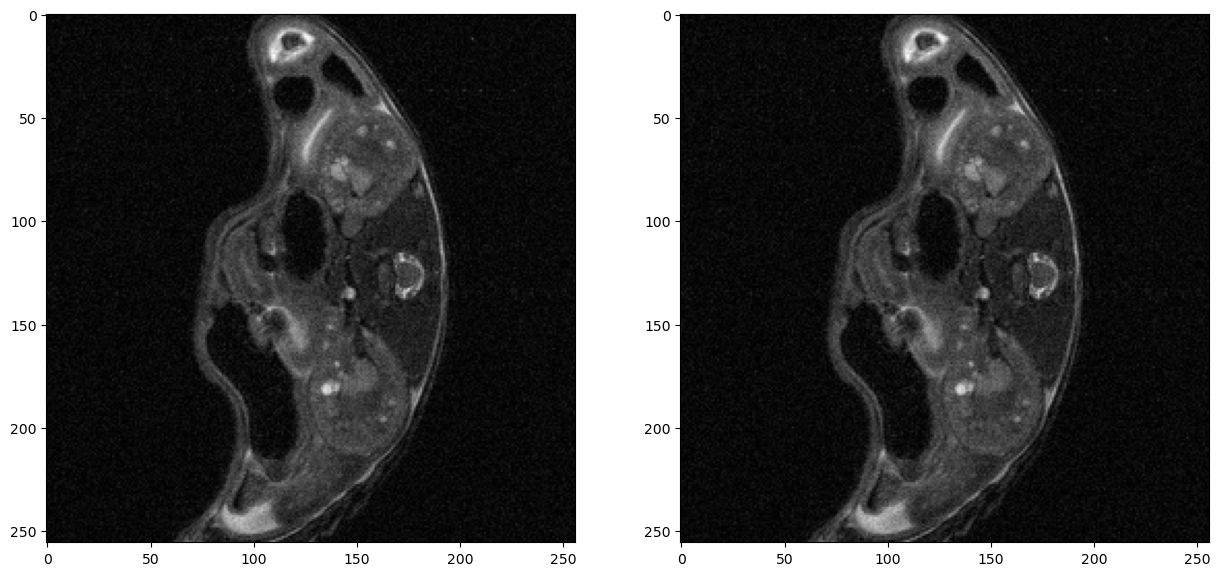

((256, 256), (256, 256))

In [160]:
# show input image slice
sliceIndex = 5
plt.figure(figsize=(15,15))
imgSlice = imgTarget[:,:,sliceIndex]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

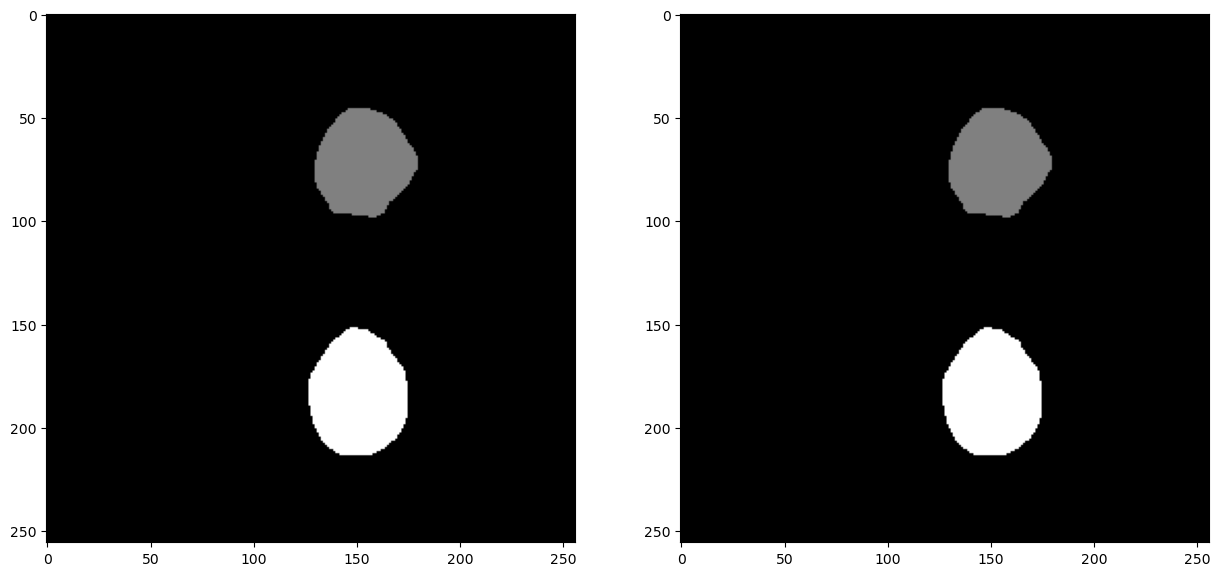

((256, 256), (256, 256))

In [161]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[:,:,sliceIndex]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


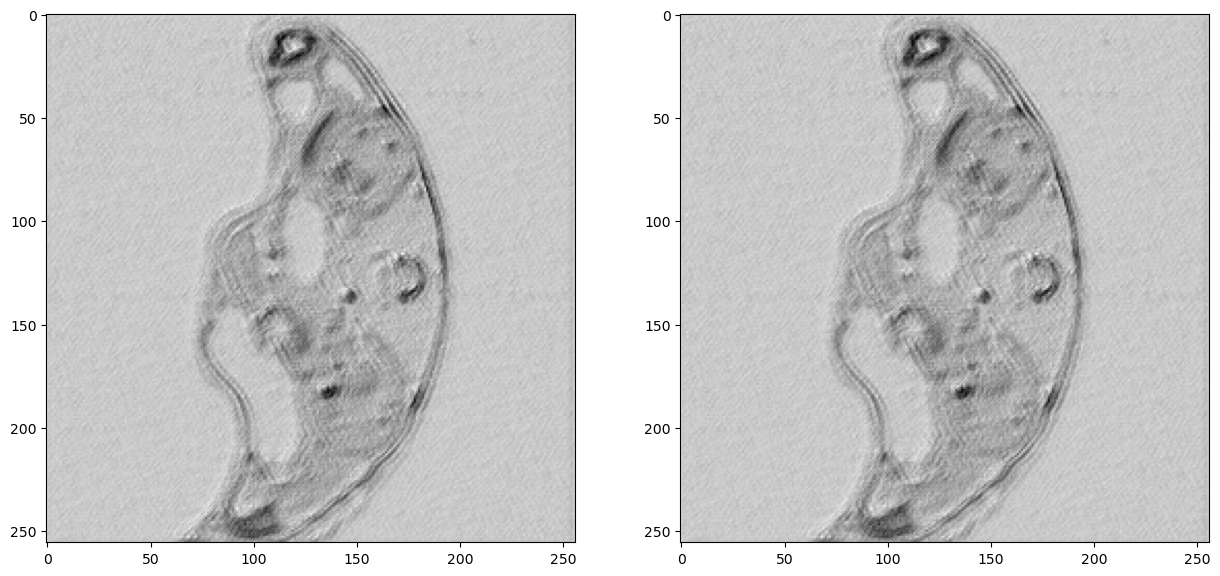

((256, 256), (256, 256))

In [162]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

### Predicting a full volume

In [163]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [164]:
predImg = predictVolume(imgTarget)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
